## Import Libraries


In [996]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split


In [997]:

# https://datascience.stackexchange.com/questions/75855/what-types-of-matrix-multiplication-are-used-in-machine-learning-when-are-they
# I wanna be able to stack layers
# idea is if tthis get passed to antoher then it will build the neural net
# build weight matrix
# get frontprop calc to work
def softmax(x):
    exps = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return exps / np.sum(exps, axis=-1, keepdims=True)

def relu(x):
    return np.maximum(0, x)

def sigmoid(x):
    return np.where(
        x >= 0,
        1 / (1 + np.exp(-x)),
        np.exp(x) / (1 + np.exp(x))
    )

def sigmoid_derivative(x):
    sig = sigmoid(x)
    return sig * (1 - sig)

def tanh(x):
    return np.tanh(x)

def binary_cross_entropy(y_pred, y_true, epsilon=1e-12):
    y_pred = np.clip(y_pred, epsilon, 1. - epsilon)
    loss = - (y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    return np.mean(loss)

def binary_cross_entropy_derivative(y_pred, y_true, epsilon=1e-12):
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return -(y_true / y_pred) + (1 - y_true) / (1 - y_pred)

def categorical_cross_entropy(y_pred, y_true,  epsilon=1e-8):
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    loss = -np.sum(y_true * np.log(y_pred)) / y_true.shape[0]
    return loss



class LinearLayer():
    def __init__(self, inFeature, outFeature, activationFunction=None) -> None:
        # self.W=np.random.randint(10, size=(outFeature, inFeature)).astype(np.float64)
        self.W = np.random.randn(outFeature, inFeature) * 0.01  # small Gaussian
        self.b = np.zeros((1, inFeature), dtype=np.float64)
        self.trainable=True
        self.activation = activationFunction
        self.dEdx=0
        self.dEdy=0
        self.y=0
        # print(self.W)
    def Forward(self, X):
        self.X = X 
        # print(f"{X.shape}:{self.W.shape}")

        output=X@self.W+self.b
        # print(output)
        if self.activation:
            output = self.activation(output)
        # print(output)

        self.y=output
        return self.y
    def Backward(self, y, lr=0.01):
        self.dEdy=self.y-y
        dydx=sigmoid_derivative(self.y)
        self.dEdx= dydx*self.dEdy
        # find out how the weight and bias affect the error
        dEdW=self.X.T@self.dEdx
        dEdb = np.sum(self.dEdx, axis=0, keepdims=True)

        self.W-=lr*dEdW
        self.b-=lr*dEdb
        return self.dEdx @ self.W.T   
    def BackwardHidden(self, dEdy, lr=0.01):
        # honestly, dont hardcode it like this, but I got no choice
        dydx=sigmoid_derivative(self.y)
        self.dEdx= dydx*dEdy
        # find out how the weight and bias affect the error
        dEdW=self.X.T@self.dEdx
        dEdb = np.sum(self.dEdx, axis=0, keepdims=True)

        self.W-=lr*dEdW
        self.b-=lr*dEdb
        return self.dEdx @ self.W.T 
    def Reset():
        pass
    def Build():
        # we want to just cache the derivative of the function
        pass



class Model():
    def __init__(self, layers) -> None:
        self.layers=layers
    def ForwardProp(self, X):
        for i in range(len(self.layers)):
            X=self.layers[i].Forward(X)
        return X
    def BackwardProp(self, y, learningRate=0.01):
        print("running backprop")
        for i, layer in enumerate(self.layers[::-1]):
            if i == 0:
                dEdx = layer.Backward(y, lr=learningRate)
            else:
                dEdx = layer.BackwardHidden(dEdx, lr=learningRate)


def toHotEncoding( classification ):
    # emulates the functionality of tf.keras.utils.to_categorical( y )
    classification = classification.astype(int)  # Ensure integer class labels
    num_samples = classification.shape[0]
    num_classes = np.max(classification) + 1
    hotEncoding = np.zeros((num_samples, num_classes), dtype=np.float32)
    hotEncoding[np.arange(num_samples), classification] = 1
    return hotEncoding

def accuracy(y_pred, y_true):
    # Get predicted class indices
    pred_labels = np.argmax(y_pred, axis=1)
    
    # Convert one-hot to class indices if needed
    if y_true.ndim == 2:
        true_labels = np.argmax(y_true, axis=1)
    else:
        true_labels = y_true

    correct = np.sum(pred_labels == true_labels)
    total = y_true.shape[0]
    return correct / total

    

In [998]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j


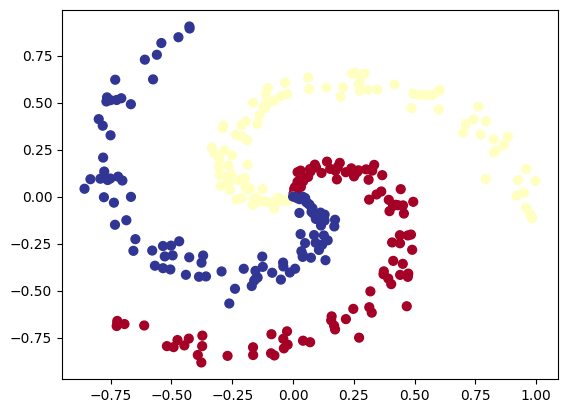

(240, 2) : (240, 3)


In [999]:

plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
plt.show()
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2, random_state=42)

y_train=toHotEncoding(y_train)
y_test=toHotEncoding(y_test)
print(f"{X_train.shape} : {y_train.shape}")

In [1000]:

layerSequence=[
LinearLayer(20,2, sigmoid)
,LinearLayer(20,20, sigmoid)
,LinearLayer(20,20, sigmoid)
# below this is the output layer
,LinearLayer(3, 20, None)
]

model = Model(layers=layerSequence)
epochs = 10
losses = [] 

for epoch in range(epochs):
    print(f"Current epoch: {epoch}")
    y_logits = model.ForwardProp(X_train)
    # print(f"{y_pred.shape} : {y_train.shape}")
    y_pred = softmax(y_logits)
    loss = categorical_cross_entropy(y_pred, y_train)
    losses.append(loss)  
    model.BackwardProp(y_train,learningRate=0.01)
    acc = accuracy(y_pred, y_train)
    print(f"Loss: {loss}, Accuracy: {acc:.2f}")



Current epoch: 0
running backprop
Loss: 1.0993817353648336, Accuracy: 0.33
Current epoch: 1
running backprop
Loss: 1.0996903278558032, Accuracy: 0.35
Current epoch: 2
running backprop
Loss: 1.0981943974361328, Accuracy: 0.35
Current epoch: 3
running backprop
Loss: 1.0983349904718593, Accuracy: 0.35
Current epoch: 4
running backprop
Loss: 1.1014323868727762, Accuracy: 0.35
Current epoch: 5
running backprop
Loss: 1.1419720274009595, Accuracy: 0.35
Current epoch: 6
running backprop
Loss: 1.8880679693449085, Accuracy: 0.33
Current epoch: 7
running backprop
Loss: 4.928888484773931, Accuracy: 0.35
Current epoch: 8
running backprop
Loss: 1.8350369120187304, Accuracy: 0.33
Current epoch: 9
running backprop
Loss: 2.6501656516539125, Accuracy: 0.33


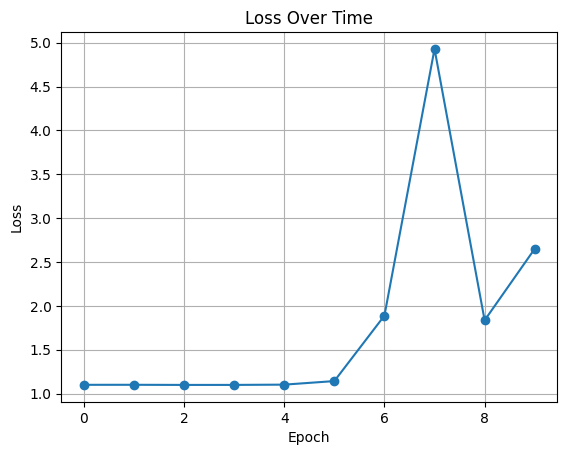

In [1001]:

plt.plot(range(epochs), losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Time')
plt.grid(True)
plt.show()

In [1002]:
import matplotlib.pyplot as plt
import numpy as np

def plot_decision_boundary(model, X, y, resolution=0.01):
    # Set min and max values for the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    # Generate a mesh grid
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, resolution),
        np.arange(y_min, y_max, resolution)
    )
    
    # Flatten grid and stack as input
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    # Predict using the model
    logits = model.ForwardProp(grid)
    probs = softmax(logits)
    predictions = np.argmax(probs, axis=1)
    
    # Reshape to match grid
    zz = predictions.reshape(xx.shape)

    # Plot decision regions
    plt.contourf(xx, yy, zz, alpha=0.5, cmap=plt.cm.coolwarm)
    plt.scatter(X[:, 0], X[:, 1], c=np.argmax(y, axis=1), s=30, edgecolor='k', cmap=plt.cm.coolwarm)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title("Decision Boundary")
    plt.show()


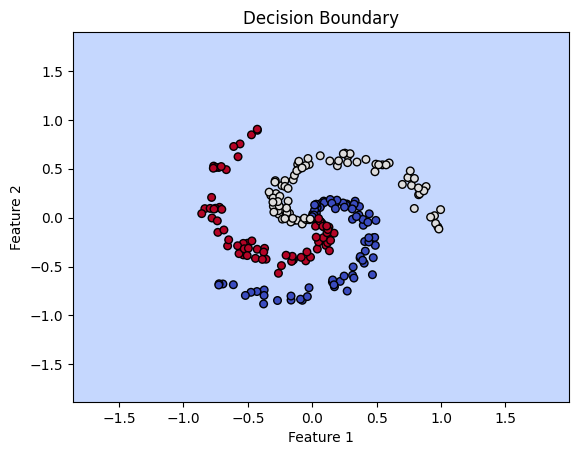

In [1003]:
plot_decision_boundary(model, X_train, y_train)